In [1]:
%matplotlib inline


# Light curve generator

In [26]:
import logging
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

log = logging.getLogger(__name__)

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel

## Select the data

We first set the datastore. Again, this is where your .fits and .fits.gz files are. 

Make sure the number of observations matches the length of your initial runlist

In [27]:
data_store = DataStore.from_dir("/raid/romulus/swong/LIV/1es/")
data_store.info()

Data store:
HDU index table:
BASE_DIR: /raid/romulus/swong/LIV/1es
Rows: 24
OBS_ID: 62672 -- 62677
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti']


Observation table:
Observatory name: 'N/A'
Number of observations: 6



In [28]:
observations = data_store.get_observations(required_irf='point-like')
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 6


You will need to change the `target_position` depending on your source. You can get this from TeVCat

In [29]:
target_position = SkyCoord(299.9991667 * u.deg, 65.1486111* u.deg, frame="icrs")
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=target_position.ra,
    lat=target_position.dec,
    radius=2 * u.deg,
)
obs_ids = data_store.obs_table.select_observations(selection)["OBS_ID"]
observations = data_store.get_observations(obs_ids,skip_missing=False,required_irf='point-like')
print(f"Number of selected observations : {len(observations)}")

Number of selected observations : 6


## Define time intervals

We create the list of time intervals. Each time interval is an
`astropy.time.Time` object, containing a start and stop time.




Duration = length of each time bin

Make sure that `duration` * `n_time_bins` = total exposure time

In [30]:
start_mjd = Time(56067.393,format='mjd')
print(start_mjd.iso)
t0 = Time("2012-05-20T09:25:55.200")
duration = 10 * u.min
n_time_bins = 14
times = t0 + np.arange(n_time_bins) * duration
time_intervals = [Time([tstart, tstop]) for tstart, tstop in zip(times[:-1], times[1:])]

2012-05-20 09:25:55.200


## Filter the observations list in time intervals

Here we apply the list of time intervals to the observations with
`~gammapy.data.Observations.select_time()`.

This will return a new list of Observations filtered by time_intervals.
For each time interval, a new observation is created that converts the
intersection of the GTIs and time interval.

Make sure the start and stop times make sense (compare UTC times to loggen)


In [31]:
short_observations = observations.select_time(time_intervals)
# check that observations have been filtered
print(f"Number of observations after time filtering: {len(short_observations)}\n")
print(short_observations[1].gti)

Number of observations after time filtering: 16

GTI info:
- Number of GTIs: 1
- Duration: 34.85832825303078 s
- Start: 230290557.2 s MET
- Start: 2012-05-20T09:35:55.200 (time standard: UTC)
- Stop: 230290592.05832824 s MET
- Stop: 2012-05-20T09:36:30.058 (time standard: UTC)



As we can see, we have now observations of duration equal to the chosen
time step.

Now data reduction and light curve extraction can proceed exactly as
before.




## Building 1D datasets from the new observations

Here we will perform the data reduction in 1D with reflected regions.

*Beware, with small time intervals the background normalization with OFF
regions might become problematic.*




### Defining the geometry

Make sure that the energy range (especially lower bound) matches the paper

Don't change `on_region_radius`

In [34]:
# Target definition
energy_axis = MapAxis.from_energy_bounds("0.315 TeV", "8 TeV", nbin=10)
energy_axis_true = MapAxis.from_energy_bounds(
    "0.315 TeV", "8 TeV", nbin=10, name="energy_true"
)

on_region_radius = Angle("0.0894427191 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

### Creation of the data reduction makers

We now create the dataset and background makers for the selected
geometry.




In [35]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

### Creation of the datasets

Now we perform the actual data reduction in the time_intervals.




In [36]:
datasets = Datasets()

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

for obs in short_observations:
    dataset = dataset_maker.run(dataset_empty.copy(), obs)

    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
    datasets.append(dataset_on_off)

/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: RuntimeWarning: invalid value encountered in cast
  p_idx = np.rint(p).astype(int)
/homes/wang/swong/lib/python3.9/site-packages/gammapy/maps/geom.py:48: Runti

## Define the Model

The actual flux will depend on the spectral shape assumed. Use what you got from the spectral analysis fit or the model/parameters in the paper.

In [37]:
spectral_model = PowerLawSpectralModel(
    index=2.6, amplitude=4.64e-12 * u.Unit("1 / (cm2 s TeV)") #from wiki ED analysis
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(spatial_model=None, spectral_model=spectral_model, name="mrk421")

### Assign to model to all datasets

We assign each dataset its spectral model




In [38]:
datasets.models = sky_model

## Extract the light curve

We first create the `~gammapy.estimators.LightCurveEstimator` for the
list of datasets we just produced. We give the estimator the name of the
source component to be fitted.

Again, `energy_edges` should match the energy bounds above and the paper. The following 2 cells will actually make your lightcurve, so this may take a while to run.


In [39]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[0.315, 8] * u.TeV,
    source=0,
    time_intervals=time_intervals,
    selection_optional=None,
)

In [40]:
lc_1d = lc_maker_1d.run(datasets)

# Overlay LC from paper

We do some funky things here to properly read in the paper values.

Make sure `header` matches your actual .ecsv header (you can copy/paste). You may need to modify the stuff below based on the columns you have in your file.

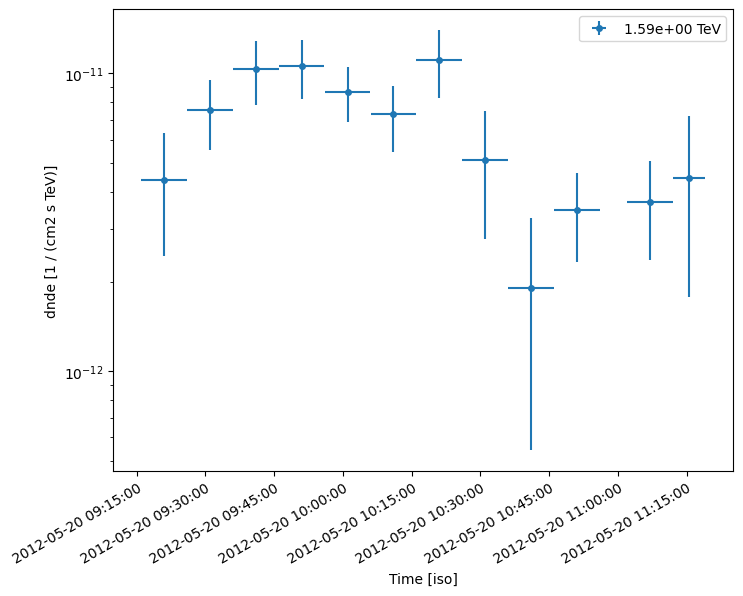

In [43]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
header="""# %ECSV 1.0
# ---
# datatype:
# - {name: time_min, datatype: float64}
# - {name: time_max, datatype: float64}
# - {name: e_ref, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: e_min, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: e_max, unit: TeV, datatype: string, subtype: 'float64[1]'}
# - {name: flux, unit: 1 / (m2 s), datatype: string, subtype: 'float64[1]'}
# - {name: flux_err, unit: 1 / (m2 s), datatype: string, subtype: 'float64[1]'}
# - {name: ts, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: sqrt_ts, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: npred, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: npred_excess, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: stat, unit: '', datatype: string, subtype: 'float64[1]'}
# - {name: is_ul, datatype: string, subtype: 'bool[1]'}
# - {name: counts, unit: '', datatype: string, subtype: 'float64[1,44]'}
# - {name: success, unit: '', datatype: string, subtype: 'bool[1]'}
# schema: astropy-2.0
time_min time_max e_ref e_min e_max flux flux_err ts sqrt_ts npred npred_excess stat is_ul counts success"""


with open("temptest.ecsv", "w") as myfile:
    myfile.write(header)

filename = "1es_paper.ecsv"

imp_tab=Table.read("1es_paper.ecsv")
imp_tab["e_max"]=imp_tab["e_cut"]
imp_tab["e_ref"]=np.exp(np.log(imp_tab["e_min"])+np.log(imp_tab["e_max"])/2)

imp_tab["time_min"]=imp_tab["e_cut"]
imp_tab["time_max"]=imp_tab["time"]+(imp_tab["time_bin"]/2.01)
imp_tab["time_min"]=imp_tab["time"]-(imp_tab["time_bin"]/2.01)

extend="[[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [0.0] [false] [[NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN]] [true]"
#for i in range(len(imp_tab)):
for i in range(len(imp_tab)):

    with open("temptest.ecsv", "a") as myfile:
        myfile.write(f'\n{imp_tab[i]["time_min"]} {imp_tab[i]["time_max"]} [{imp_tab[i]["e_ref"]}] [{imp_tab[i]["e_min"]}] [{imp_tab[i]["e_max"]}] [{imp_tab[i]["flux"]}] [{imp_tab[i]["flux_err"]}] [0] [0] {extend}')


from gammapy.estimators import FluxPoints
lc_test=FluxPoints.read('temptest.ecsv',reference_model=spectral_model,sed_type='flux',format='lightcurve')
plt.figure(figsize=(8, 6))
lc_test.plot(sed_type='dnde',marker="o")
plt.show()

# Overlay our Gammapy results with the paper



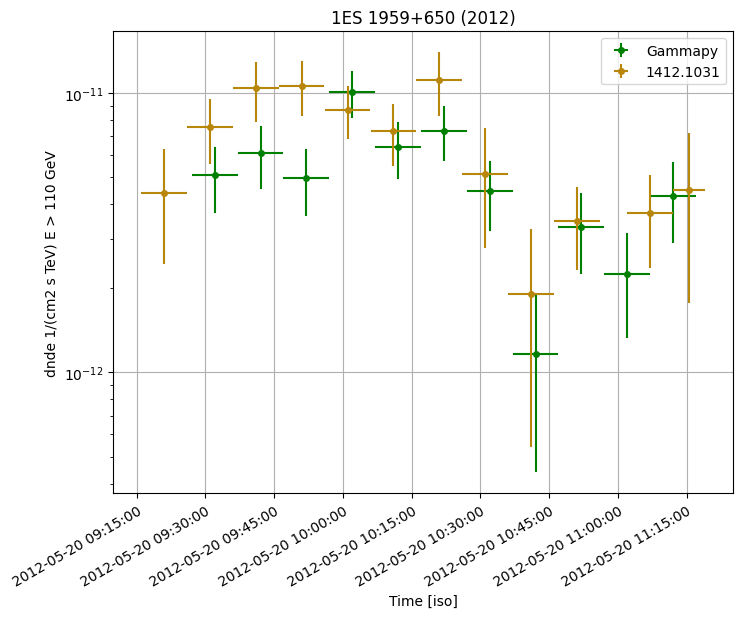

In [44]:
plt.figure(figsize=(8, 6))
lc_1d.plot(marker="o",color='g',label='Gammapy')
lc_test.plot(sed_type='dnde',marker="o",color='darkgoldenrod',label='1412.1031')
#lc_test2.plot(sed_type='dnde',marker="o",label='Eventdisplay')
plt.ylabel('dnde 1/(cm2 s TeV) E > 110 GeV')
plt.title('1ES 1959+650 (2012)')
plt.grid()
plt.show()

We'll save these values to a file for later

In [46]:
out = lc_1d.to_table(sed_type='dnde',format='lightcurve')
display(out)
out.write('mrk421_lc_values.ecsv', overwrite=True)  

time_min,time_max,e_ref,e_min,e_max,dnde,dnde_err,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success
,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,16]","float64[1,16]",float64[1],bool[1],"float64[1,16]",bool[1]
56067.39376601852,56067.400710462956,1.5874507866387542,0.315,7.999999999999999,5.069217083231274e-12,1.3466764087437628e-12,43.93308214552986,6.628203538329965,nan .. nan,nan .. nan,20.597291503549577,False,nan .. nan,True
56067.400710462956,56067.4076549074,1.5874507866387542,0.315,7.999999999999999,6.073561742528918e-12,1.5319060115993427e-12,66.80262068578098,8.173287018438847,nan .. nan,nan .. nan,8.451207711910067,False,nan .. nan,True
56067.4076549074,56067.41459935185,1.5874507866387542,0.315,7.999999999999999,4.974383861841778e-12,1.3351621400564416e-12,47.33848415311505,6.880296807050917,nan .. nan,nan .. nan,12.32746854865749,False,nan .. nan,True
56067.41459935185,56067.42154379629,1.5874507866387542,0.315,7.999999999999999,1.0062194813135277e-11,1.9433280110686165e-12,102.98966884343692,10.148382572776654,4.331267474633855 .. nan,4.196356296539307 .. nan,18.17481733496946,False,5.0 .. nan,True
56067.42154379629,56067.42848824074,1.5874507866387542,0.315,7.999999999999999,6.3913197603160095e-12,1.4891193381289931e-12,68.27620225922503,8.262941501621867,nan .. nan,nan .. nan,18.446541254578168,False,nan .. nan,True
56067.42848824074,56067.43543268518,1.5874507866387542,0.315,7.999999999999999,7.329712506310145e-12,1.6343353788992794e-12,75.36260704411914,8.681163922200707,nan .. nan,nan .. nan,24.2689792557302,False,nan .. nan,True
56067.43543268518,56067.44237712963,1.5874507866387542,0.315,7.999999999999999,4.467463714981508e-12,1.257663120449891e-12,43.99938305903005,6.6332030768724435,nan .. nan,nan .. nan,7.694197162479649,False,nan .. nan,True
56067.44237712963,56067.44932157407,1.5874507866387542,0.315,7.999999999999999,1.163561791303915e-12,7.249117784209922e-13,5.1476684290041135,2.268847378957896,nan .. 2.4846334316268117,nan .. 2.1475298404693604,7.640175870815185,False,nan .. 4.0,True
